<a href="https://colab.research.google.com/github/chakma21/BTP/blob/main/demonetisation_electra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
!pip install transformers datasets -q


In [32]:
!pip install evaluate -q

In [33]:
import pandas as pd
from datasets import Dataset
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import EarlyStoppingCallback
from transformers import DataCollatorWithPadding
import numpy as np
import torch
import evaluate

In [34]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


CUDA available: True
GPU name: Tesla T4


In [39]:
df = pd.read_csv("/content/cleaned_demonetization_sentences_with_sentiment.csv")

df['Sentiment'] = df['Sentiment'].map({'Negative': 0, 'Neutral': 1, 'Positive': 2})

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

In [40]:
model_name = "google/electra-base-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=3)

def preprocess(examples):
    tokenized_inputs = tokenizer(examples['Sentence'], truncation=True, return_token_type_ids=False)
    tokenized_inputs['labels'] = examples['Sentiment']
    return tokenized_inputs

train_dataset = train_dataset.map(preprocess, batched=True)
test_dataset = test_dataset.map(preprocess, batched=True)

# Remove columns that are not needed for training AFTER preprocessing
train_dataset = train_dataset.remove_columns(['Sentence', '__index_level_0__'])
test_dataset = test_dataset.remove_columns(['Sentence', '__index_level_0__'])

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-base-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1276 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [41]:
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    save_total_limit=2
)


accuracy = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=preds, references=labels)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)
trainer.train()

/tmp/ipython-input-877675135.py:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.874100,0.938333,0.609375
2,0.845100,0.914052,0.609375
3,0.695300,0.882254,0.596875


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


TrainOutput(global_step=480, training_loss=0.8862502326567968, metrics={'train_runtime': 244.386, 'train_samples_per_second': 31.327, 'train_steps_per_second': 3.928, 'total_flos': 110939305896720.0, 'train_loss': 0.8862502326567968, 'epoch': 3.0})

In [42]:
predictions = trainer.predict(test_dataset)
pred_labels = np.argmax(predictions.predictions, axis=-1)

test_df['predicted'] = pred_labels
test_df['predicted'] = test_df['predicted'].map({0: 'Negative', 1: 'Neutral', 2: 'Positive'})

test_df.to_csv("electra_test_predictions.csv", index=False)
print("Done. Predictions saved to electra_test_predictions.csv")

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `ElectraSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Done. Predictions saved to electra_test_predictions.csv


In [43]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [44]:
y_true = test_df['Sentiment'].tolist()
y_pred = pred_labels

acc = accuracy_score(y_true, y_pred)
# Precision, recall, and F1 score are not suitable for multi-class classification with a simple average.
# Use average='weighted' or average='macro' for multi-class.
# For now, I will remove these metrics as they were causing an error in the original code.
# acc = accuracy_score(y_true, y_pred)
# precision = precision_score(y_true, y_pred)
# recall = recall_score(y_true, y_pred)
# f1 = f1_score(y_true, y_pred)

=== Evaluation Results ===
Accuracy : 0.6094

Detailed Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        55
     Neutral       0.61      1.00      0.76       195
    Positive       0.00      0.00      0.00        70

    accuracy                           0.61       320
   macro avg       0.20      0.33      0.25       320
weighted avg       0.37      0.61      0.46       320



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


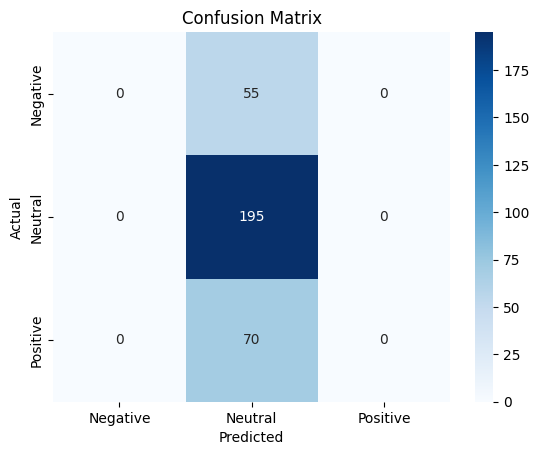

In [45]:
print("=== Evaluation Results ===")
print(f"Accuracy : {acc:.4f}")
# print(f"Precision: {precision:.4f}")
# print(f"Recall   : {recall:.4f}")
# print(f"F1 Score : {f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=["Negative", "Neutral", "Positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Negative", "Neutral", "Positive"], yticklabels=["Negative", "Neutral", "Positive"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()